# Chapter 7: Fine-tuning to follow instructions

## 7.1 Introduction to instruction fine-tuning

#### We know that a pretrained LLM is capable of text completion, meaning it can finish sentences or write text paragraphs given a fragment as input. However, pretrained LLMs often struggle with specific instructions, such as, "Fix the grammer in this text" or "Convert this text to passive voice". 

#### We will focus on improving the LLMs ability to follow such instruction and generate a desired response. 

<div style="max-width:700px">
    
![](images/7.1_1.png)

</div>

#### We we will begin with the first stage in the three stage instruction fine-tuning process.

<div style="max-width:700px">
    
![](images/7.1_2.png)

</div>


## 7.2 Preparing a dataset for supervised instruction fine-tuning

#### We will download and format the instruction dataset for instruction fine-tuning a pre-trained LLM. This dataset contains 1,100 instruction-response pairs similar to those in the first figure.

In [1]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)


data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


#### This code implements and executes a function that downloads the dataset and puts it into JSON format.

In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


#### As we can see, each example is a dictionary containing 'instruction', 'input', and 'output'.

In [3]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


#### As shown above, the 'input' field may occasionally be empty.

#### Instruction fine-tuning involves training a model by providing it explicit input-output pairs. There are various ways to format these entires for LLMs. The figure below showcases two different example formats, known as 'prompt styles', used in the training of LLMs such as Alpaca and Phi-3.

<div style="max-width:800px">
    
![](images/7.2_1.png)

</div>

#### We will use the Alpaca prompty style because it is one of the most popular ones.

#### Lets define a 'format_input' function that we can use to convert the entires in the data list into the Alpaca-style input format.

In [4]:
def format_input(entry):
    instruction_text = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{entry['instruction']}"
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else " "
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


#### Before we set up dataloaders, lets partition the dataset into a training, validation and test set.

In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


#### Now we can focus on developing the method for construction training batches for fine-tuning the LLM

## 7.3 Organizing data into training batches

<div style="max-width:700px">
    
![](images/7.3_1.png)

</div>

#### Previously, the training batches were created automatically by the PyTorch DataLoader class, which employs a 'collate' function to combine lists of samples into batches. A collate function takes a list of individual samples and merges them into a single batch.

#### However, for instruction fine-tuning, we are required to create our own collate function that plug into the DataLoader. We implement this custom collate function to handle the specific requirements and formatting our instruction fine-tuning dataset.

<div style="max-width:700px">
    
![](images/7.3_2.png)

</div>

#### The figure above breaks down the batching process into several steps. 

#### First, to implement steps 2.1 and 2.2, we create an InstructionDataset class that applies format_input and pretokenizes all inputs in the dataset. This two step process is detailed below, and is implemented in the __init__ constructor method of the InstructionDataset class.

<div style="max-width:800px">
    
![](images/7.3_3.png)

</div>

In [7]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n###Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

#### Similar to the approach used for classification fine-tuning, we want to collection multiple training examples in a batch, which necessitates padding all inputs to the same length which we do by appending the token ID for the <|endoftext|> token to the pretokenized inputs directly.

#### Moving onto step 2.3 of the process, we develop a custom collate function that we can pass to the data loader. This custom collate function pads the training example in each batch to the same length while allowing different batches to have different lengths. This way, we avoid unncessary padding by only extending sequences to the longest one in the batch, not the whole dataset.

<div style="max-width:700px">
    
![](images/7.3_4.png)

</div>

In [8]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # finds longest sequences in the batch
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [9]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


#### We have implemented our first custom collate function to create batches from lists of inputs. Now, we must modify it to also create the target token IDs corresponding to the batch of input IDs.

<div style="max-width:700px">
    
![](images/7.3_5.png)

</div>

In [10]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # finds longest sequences in the batch
    inputs_lst, target_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        target_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(target_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


#### We want to assign a -100 placeholder value to all padding tokens. This allows us to exlude these padding tokens from contributing to the training loss calculation, ensuring that only meaningful data influences model learning. (We did not have to worry about this for classification fine-tuning because we only trained the model based on the last output token.)

#### Note that we retain one end-of-text token, ID 50256, in the target list, this allows the LLM to learn when to generate an end-of-text token in reponse to instruction. This is used as an indicator that the generated response is complete.

#### Now we modify our collate function to replace tokens with ID 50256 with -100 in target lists. We also introduce a allowed_max_length parameter to optionally limit the length of samples.

<div style="max-width:800px">
    
![](images/7.3_6.png)

</div>

In [11]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item)) # pads sequence to max_length
        inputs = torch.tensor(padded[:-1]) # truncates to last token for input
        targets = torch.tensor(padded[1:]) # shifts +1 to the right for targets

        mask = targets == pad_token_id # replaces all but the first padding tokens in targets by ignore_index
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [12]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


#### Lets explore the underlying purpose of this modification

#### Consider this simple and self-contained example where each output logit corresponds to a potential token from the models vocabulary. Here's how we calculate cross entropy loss during training when the model predicts a sequence of tokens.

In [13]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


#### Loss value calculated for previous code is 1.1269, and as we would expect, adding an additional token ID affects the loss calculation:

In [14]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


#### Now lets see what happens when we replace the third target token ID with -100:

In [15]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


#### The cross entropy loss function ignored the third entry in the targets_3 vector, the token ID corresponding to -100. The default setting of the cross entropy function in PyTorch ignores all targets labeled -100, and we can take advantage of this ignore additional padding tokens that we used to pad the trianing examples to have the same length in each batch.

#### However, we want to keep one end-of-text token because it helps the LLM learn to generate end-of-text tokens, which we can use to indicate that a response is complete.

#### In addition to masking out padding tokens, it is also common to mask out the target token IDs that correspond to the instruction. This results in the crosss entropy loss only being computed for the generated response target IDs, thus the model is trained to focus on generating accurate responses rather than memorizing instructions, which can help reduce overfitting.

## 7.4 Creating data loaders for an instruction dataset

#### We are ready to plug both InstructionDatset and the custom_collate_fn function into PyTorch data loaders.

<div style="max-width:1000px">
    
![](images/7.4_1.png)

</div>

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device", device)

Device mps


In [17]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [18]:
from torch.utils.data import DataLoader
import tiktoken

num_workers = 0
batch_size = 1
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [19]:
count = 0
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    count += 1
    if count > 10:
        break
    

Train loader:
torch.Size([1, 61]) torch.Size([1, 61])
torch.Size([1, 49]) torch.Size([1, 49])
torch.Size([1, 56]) torch.Size([1, 56])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 58]) torch.Size([1, 58])
torch.Size([1, 45]) torch.Size([1, 45])
torch.Size([1, 58]) torch.Size([1, 58])
torch.Size([1, 44]) torch.Size([1, 44])
torch.Size([1, 63]) torch.Size([1, 63])
torch.Size([1, 48]) torch.Size([1, 48])


#### Thanks to our custom collate function, the data loader is able to create batches of with differing token sequence lengths

## 7.5 Loading a pretrained LLM

#### Now we load a pretrained GPT model that we want to fine-tune. Unlike before, when we loaded in the gpt-small model, this time we will load in the gpt-medium model because the small is too limited in capacity to achieve satisfactory results via instruction fine-tuning.

<div style="max-width:1000px">
    
![](images/7.5_1.png)

</div>

In [20]:
import os
from previous_chapters import GPTModel

BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small-124M": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium-355M": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large-774M": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl-1558M": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium-355M"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

file_name = f"{CHOOSE_MODEL}.pth"
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")


model = GPTModel(BASE_CONFIG).to(device)
model.load_state_dict(torch.load(file_name, map_location=device, weights_only=True), strict=True)
model.eval()
print("")

#### Lets assess the pretrained LLM's performance on one of the validation tasks by comparing its output to the expected response. 

In [21]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.' 


In [22]:
from previous_chapters import text_to_token_ids, token_ids_to_text, generate

idx = text_to_token_ids(input_text, tokenizer).to(device)
token_ids = generate(model=model, idx=idx, max_new_tokens=35, context_size=BASE_CONFIG["context_length"], eos_id=50256)
generated_text = token_ids_to_text(token_ids, tokenizer)

#### The generate function concatenates the input and output text, but we only want to see the generated response so we can subtract the length of the input instruction from the start of generated text

In [23]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

__________________________________________

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.' __________________________________________

### Instruction


## 7.6 Fine-tuning the LLM on instruction data

#### Now we take the loaded pretrained model and further train it using the previously prepared instruction dataset prepared earlier in the chaper. 

<div style="max-width:1000px">
    
![](images/7.6_1.png)

</div>

In [24]:
from previous_chapters import calc_loss_loader
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
torch.mps.empty_cache()

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.788628101348877
Validation loss: 3.97882661819458


#### Initial loss values are above, remember, our goal is to minimize the loss.

In [25]:
from previous_chapters import train_model_simple
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000625, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=10, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.072, Val loss 3.095
Ep 1 (Step 000100): Train loss 0.874, Val loss 1.017
Ep 1 (Step 000200): Train loss 0.666, Val loss 0.978
Ep 1 (Step 000300): Train loss 0.572, Val loss 0.878
Ep 1 (Step 000400): Train loss 0.941, Val loss 0.846
Ep 1 (Step 000500): Train loss 0.747, Val loss 0.842
Ep 1 (Step 000600): Train loss 0.657, Val loss 0.816
Ep 1 (Step 000700): Train loss 0.569, Val loss 0.721
Ep 1 (Step 000800): Train loss 0.437, Val loss 0.739
Ep 1 (Step 000900): Train loss 0.374, Val loss 0.623
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'   ###Response: The meal is prepared by the chef every day.<|endoftext|>The chef prepares the meal every day.<|endoftext|>The following is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction:
Ep 2 (Step 00100

#### The training output shows the model is learning effectively, as we can tell by the consistently decreasing training and validation loss over the two epochs. 

#### We will revisit and evaluate the response quality of the model in more detail later. For now lets examine the training loss and validation curvees to gain additional insight into the model's learning process.

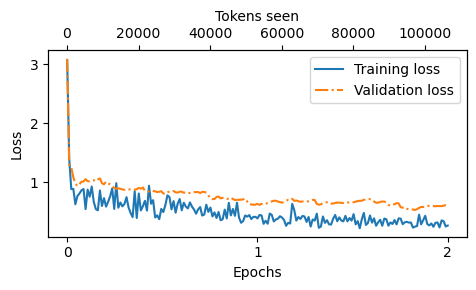

In [26]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### From the loss plot shown above, we can see that the model's performance on both the training and validation sets improves substantially over the course of training. Then as training progresses to the second epoch, the losses continue to decrease but at a slower rate, suggesting that the model is fine-tuning its learned representations and converging to a stable solution.

## 7.7 Extracting and saving responses

#### Having fine-tuned the model on the training portion of the instruction dataset, we are now ready to evaluate its performance on the held-out test set. 

#### First, we extract the model-generated responses for each input in the test dataset and collect them for the manual analysis, and then we evaluate the LLM to quantify the quality of the responses.
<div style="max-width:1000px">
    
![](images/7.7_1.png)

</div>

#### To complete the response instruction step, we use the generate function. We then print the model responses alongside the expected test set answers for the first three test set entries.

In [28]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device), max_new_tokens=256, context_size=BASE_CONFIG["context_length"], eos_id=50256)
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("###Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("--------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
--------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms? 

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud is a cumulus (thin) cumulus (thin) cloud.
--------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'. 

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudic

#### As we can see based on the test set instructions, given response, and the model's responses, the model performs relatively well.

#### More importantly, model evaluation is not as straightforward as it for classification fine-tuning, where we simply calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy. In practice, instruction fine-tuned LLMs such as chatbots are evaluated via multiple approaches:
- #### Short answer and multiple choice benchmarks
- #### Human preference comparison to other LLMs
- #### Automated conversational benchmarks

#### In practice it is useful to consider all three types of evaluation methods, however, since we are primarily interested in assessing conversational performance rather than just the ability to answer multiple choice questions, human evaluation and automated metrics may be more relevant

#### Human evaluations, while providing valuable insights, is relatively laborious and time consuming. Reading and assigning ratings to all 1,100 responses would require significant amount of effort. 

#### So, we implement an approach similar to conversational benchmarks, which involves evaluating the responses automatically using another LLM. This allows us to efficiently assess the quality of the generated responses without the need for extensive human involvement. 

#### We will use another LLM to evaluated our fine-tuned models responses, however instead of rely on a public benchmark dataset, we will use our own custom set. This allows for more targeted and relevant assessment of the model's performance within the context of our intended use case.

#### To prepare responses for this evaluation process, we appened the generated responses to the test_set dictionary, and save the updated data as an "instruction-data-with-response.json" file for record keeping. The following code will iterate over the entire test set and append the responses to the test_set dictionary.

In [31]:
for i, entry in enumerate(test_data):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("###Response:", "").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as f:
    json.dump(test_data, f, indent=4)

In [32]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


#### Lets save the model before we proceed.

In [34]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium-355M-sft.pth


## 7.8 Evaluating the fine-tuned LLM

#### We previously judged the performance of the model of an instruction-fine-tuned model by looking at its responses on three examples of the test set. Now we implemente a method to automate the response evaluation of the fine-tuned LLM using another, larger LLM.

<div style="max-width:1000px">
    
![](images/7.8_1.png)

</div>

#### We will utilize an existing instruction fine-tuned model, Llama 3. Download an application called Ollama and make sure it is running. The following code will verify that the Ollama session is running properly before we use it to evaluate the test set responses.

In [43]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError("Ollama is not running. Launch it before proceeding.")
print("Ollama running:", ollama_running)

Ollama running: True


#### The following code interacts with Ollama using its REST API

In [40]:
import urllib.request as req
def query_model(prompt, model="llama3.2", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    
    request = req.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with req.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [41]:
model = "llama3.2"
result = query_model("What do llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy or alfalfa, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and energy.
3. Grains: Llamas may also be fed grains like oats, corn, or barley, but these should not make up more than 10-15% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach and a large cecum (a specialized part of the large intestine). This allows them to break down and extract nutrients

#### Using the query_model function defined earlier, we can evalaute the responses generated by our fine-tuned model that prompts the Llama 3 model to rate our fine-tuned model's responses on a scale from 1 to 100 based on the given test set response as reference

#### Lets first apply it to three examples from the tests set

In [42]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and the correct output `{entry["output"]}`, "
        f"score the model response `{entry["model_response"]}` "
        f"on a scale from 0 to 100, where 100 is the best score."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> To complete this task, I would rewrite the sentence using a simile.

### Input:
The car is very fast.
### Output:
The car is as fast as lightning.

Now, let's evaluate the model response "The car is as fast as a bullet." on a scale from 0 to 100:

Score: 80

This response uses a simile, which meets the requirement. However, it's not the most common or idiomatic way to express speed in this context. The original response "as fast as lightning" is more commonly used and evokes a stronger sense of speed and power. The model response "as fast as a bullet" is also acceptable but might be considered less vivid or memorable than the original.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud is a cumulus (thin) cumulus (thin) cloud.

Score:
>> I would score the model

#### The generated responses show how the LLama3 model is able to provide a score for the model outputs. We can modify the previous prompt to request LLama3 to only generate an integer score from 0 to 100. This change allows us to calculate an average score for our model. 

In [48]:
def generate_model_scores(json_data, json_key, model='llama3.2'):
    scores = []
    for entry in json_data:
        prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and the correct output `{entry["output"]}`, "
        f"score the model response `{entry[json_key]}` "
        f"on a scale from 0 to 100, where 100 is the best score. "
        f"Only Respond with the integer score on a scale from 0 to 100, no other text."
    )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

#### We can now apply the generate_model_scores function to the entire test_data set

In [49]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Number of scores: 110 of 110
Average score: 45.64



#### The evaluation output shows that our fine-tuned model achieves an average score of 46, which provides a useful benchmark for comparison against other models or for experimenting with different training configurations to improve the models performance.